In [57]:
import pandas as pd
import sys
from openpyxl import load_workbook
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Matplotlib settings all LATEX
import matplotlib
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size":20})
rc("text", usetex=True)

In [58]:
# from nuclearpy_models.models.rc import sr_rc, mnp_rc
import sys
sys.path.append('../../nuclearpy_models')
from models.rc import sr_rc, mnp_rc

In [59]:
# import shap values
import shap

In [60]:
exp_df = pd.read_csv('../../Data/Experimental/rc.csv', delimiter=',').query("Z>12").drop_duplicates(subset=['Z', 'N']).query("Z<=50")#.sample(200)
exp_df["A"] = exp_df["Z"] + exp_df["N"]

In [61]:
def get_predictions_per_index(Z, N, max_index):
    return [ sr_rc.predict_index(Z, N, i) for i in range(0, max_index) ]

In [62]:
sr_rc.predict_index(20, 20, 2)

0.0

In [63]:
predictions_per_term = [get_predictions_per_index(Z, N, 5) for Z, N in zip(exp_df["Z"], exp_df["N"])]
target_per_term = [x["Rav"] for x in exp_df.to_dict(orient="records")]

In [64]:
new_df = pd.DataFrame(predictions_per_term, columns=[f"term_{i}" for i in range(5)])
# scale by hand
for col in new_df.columns:
    new_df[col] = new_df[col] / new_df[col].max()

In [65]:
new_df["Rav"] = target_per_term
new_df

,term_0,term_1,term_2,term_3,term_4,Rav
0,0.669190,-1.611313,-0.086827,0.175926,0.021977,3.0610
1,0.680885,-1.415219,-0.155927,0.090209,0.019387,3.1224
2,0.680991,-1.417615,0.131305,0.175712,0.018008,3.1176
3,0.681102,-1.143949,0.068691,0.155009,0.016374,3.1336
4,0.690562,-0.911892,-0.227175,0.059445,-0.015712,3.1889
...,...,...,...,...,...,...
332,0.994182,-0.082921,0.106058,-0.369474,0.000000,4.6921
333,0.995629,-0.163290,0.068593,-0.369474,0.000000,4.6934
334,0.997081,-0.082523,0.038428,-0.369474,0.000000,4.7019
335,0.998538,-0.162892,0.015564,-0.369474,0.000000,4.7078


# Remarkable plots

In [66]:
# Train a linear model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Make a linear model with standard scaler
from sklearn.preprocessing import StandardScaler

model = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns=["Rav"]), new_df["Rav"])
model.fit(X_train, y_train)


RandomForestRegressor()

In [67]:
# Now we can use SHAP to explain the model's output

# Create a SHAP explainer
shape_explainer = shap.Explainer(model, X_train.values)


In [68]:
shap_values = shape_explainer(X_train)

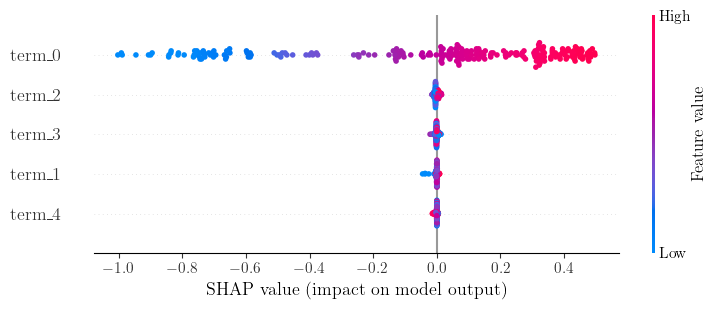

In [69]:
# plot the SHAP values for the model
shap.summary_plot(shap_values)


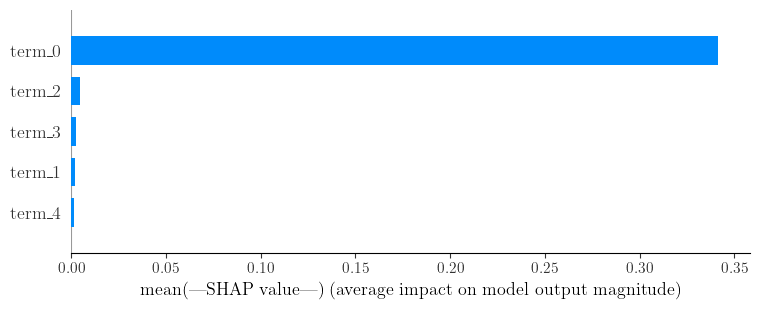

In [70]:
# see the effects of each term
shap.summary_plot(shap_values, plot_type="bar")

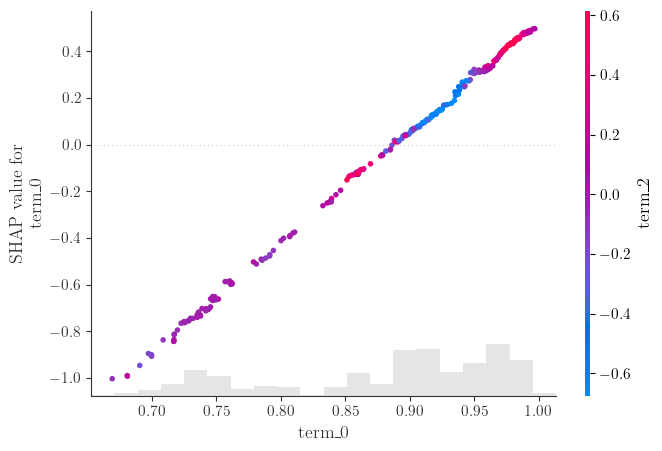

In [71]:
# correlation plot between the terms shaps and the output
shap.plots.scatter(shap_values[:, "term_0"], color=shap_values)

In [72]:
model_predictions = model.predict(X_test)
model_errors = model_predictions - y_test
np.sqrt(mean_squared_error(y_test, model_predictions))


0.019546615614684505

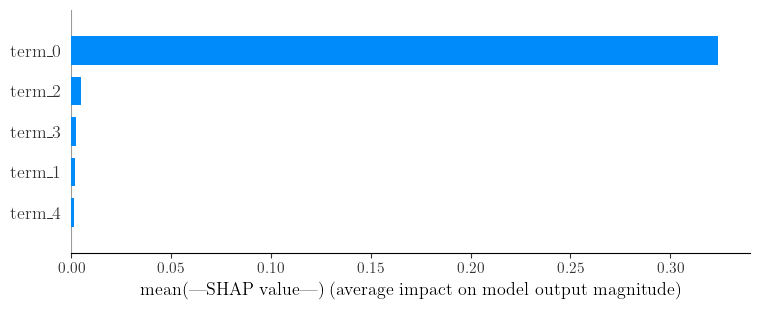

In [73]:
# Generate SHAP values for X_test
shap_values_test = shape_explainer(X_test)

# Dependence between the columns values and the error of the model predictions
shap.summary_plot(shap_values_test, X_test, plot_type="bar")